In [45]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import convolve
import random

Local Polynomial Approximation
-------------------------------
Set the parameters

In [46]:
# maximum degree of polynomial used for fitting
N = 2

# filter size
M = 51

# large M, small N -> a lot of bias when frequency increases
# N = 2
# M = 51

# large M, large N -> smaller bias than before, but a lot of variance in smooth regions
# N = 7
# M = 51

# small M, small N -> smaller bias everywhere, higher variance
# N = 2
# M = 5

# M small, M = N,  -> smaller bias than before, higher variance than before
# N = 5
# N = M

Generate synthetic signal signal

In [47]:
LENGHT = 1000

ty = np.linspace(0, 1, LENGHT)
y = np.sin(2 / (ty + 0.05))

#  noise standard deviation
sigma = 0.1

# noisy signal
s = y + sigma*np.random.normal(size=LENGHT)


Text(0.5, 1.0, 'Input Signal')

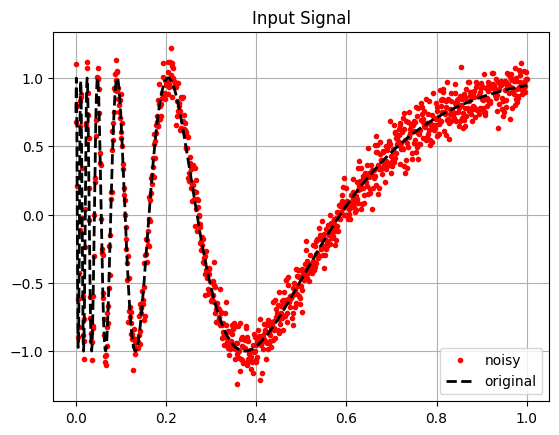

In [48]:
plt.figure()
plt.plot(ty, s, 'r.')
plt.plot(ty, y, 'k--', linewidth=2)
plt.grid()
plt.legend(['noisy', 'original'])
plt.title('Input Signal')

Define the matrix T containing the polynomials sampled over the window


In [49]:
t = np.arange(1,M+1)
T = np.ones((M,N+1))
T[:,1] = t
for i in range(2,N+1):
  T[:,i] = T[:,i-1] * t

Look at the matrix T, the columns correspond to polynomials sampled over the interval [0,1]


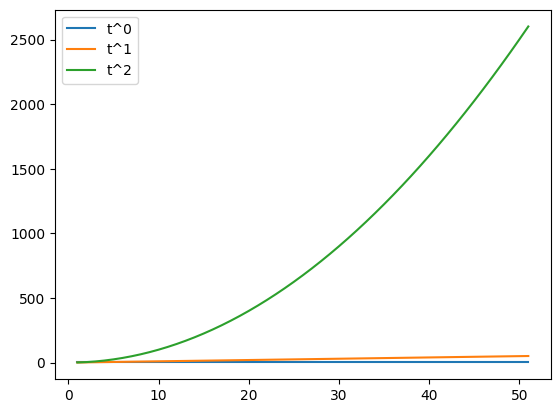

In [50]:
plt.figure()
leg = []
for l in range(N+1):
    plt.plot(t, T[:, l])
    leg.append(f't^{l:d}')
plt.legend(leg)

Construct the LPA kernel

In [51]:
# comput the qr decomposition of WT
# since T has more rows than columns, then qr computes only the first N + 1 columns of Q and the first N + 1 rows of R.
Q, R = np.linalg.qr(T, mode="reduced")

# select the central row of W2Qtilde
row =  Q[Q.shape[0]//2]

# compute the kernel
g = row @ Q.T

# flipping, since it is used in convolution
g = np.flip(g)

Text(0.5, 1.0, 'M = 51, N = 2')

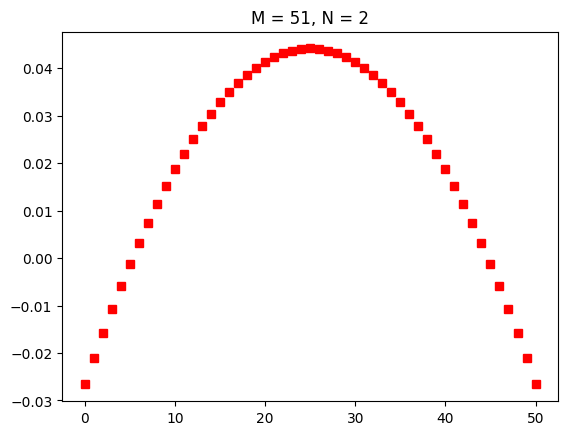

In [53]:
plt.figure()
plt.plot(g, 'rs', linewidth=3)
plt.title(f'M = {M:d}, N = {N:d}')

Filtering

In [54]:
shat = np.convolve(s,g, mode='same')

#s_pad = np.pad(s, (M//2, M//2), mode='constant')
#shat = np.zeros(LENGHT)
#for i in range(0,LENGHT):
#  shat[i] = np.convolve(g,s_pad[i:i+M], 'valid')[0]

Text(0.5, 1.0, 'M = 51, N = 2')

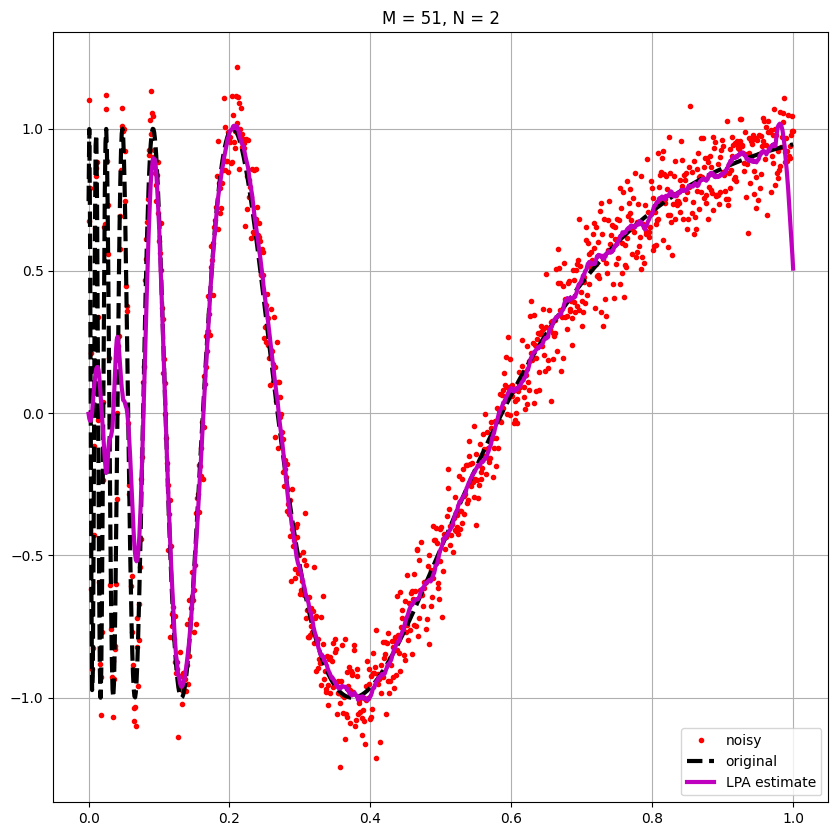

In [55]:
plt.figure(figsize=(10,10))
plt.plot(ty, s, 'r.')
plt.plot(ty, y, 'k--', linewidth=3)
plt.plot(ty, shat, 'm-', linewidth=3)
plt.grid()
plt.legend(['noisy', 'original', 'LPA estimate'])
plt.title(f'M = {M:d}, N = {N:d}')


Weighted LPA
--------------
Set the parameters

In [56]:
# maximum degree of polynomial used for fitting
N = 2

# filter size
M = 53

# half filter size
HFS = int((M-1)/2)

# set the weights. Here weights simply define the window size
w = np.zeros(M)

# centered kernel
wc = w.copy()
wc[int(HFS/2):-int(HFS/2)] = 1

# left kernel
wl = w.copy()
wl[:HFS+1] = 1

# right kernel
wr = w.copy()
wr[-HFS-1:] = 1


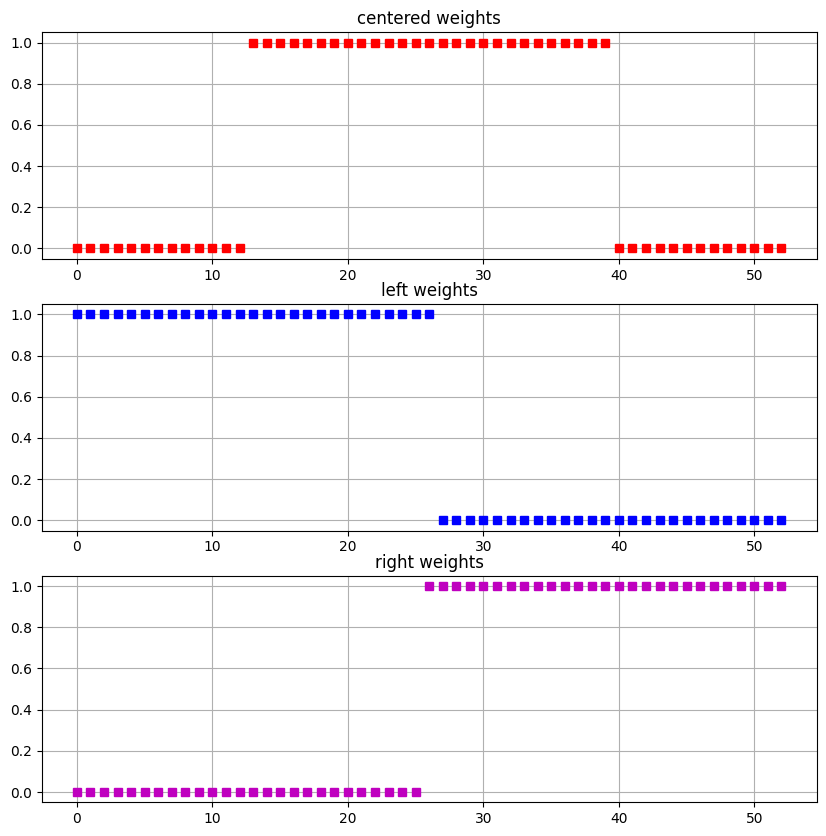

In [57]:
fig, ax = plt.subplots(3, 1, figsize=(10,10))
ax[0].plot(wc, 'rs', linewidth=3)
ax[0].set_title('centered weights')
ax[0].grid()
ax[1].plot(wl, 'bs', linewidth=3)
ax[1].set_title('left weights')
ax[1].grid()
ax[2].plot(wr, 'ms', linewidth=3)
ax[2].set_title('right weights')
ax[2].grid()


Build the weight matrix

In [58]:
# select a single weight to be used in what follows
w = wr

# generate the inverse of weights
# set to zero weights that are inf
winv = np.zeros(w.size)
for i in range(w.size):
  if(w[i] == 0):
    winv[i] = 0
  else:
    winv[i] = 1/w[i]

# define the weight matrix
W = np.diag(w)
Winv = np.diag(winv)

Generate synthetic signal signal

In [59]:
LENGHT = 1000

# clean signal
ty = np.linspace(0, 1, LENGHT)
y =  8*ty**2 - 2*ty + 2;
y[LENGHT//2 : LENGHT] = y[LENGHT//2 : LENGHT] + 7;

#  noise standard deviation
sigma = 0.2

# noisy signal
s = y + sigma*np.random.normal(size=LENGHT)

Text(0.5, 1.0, 'Input Signal')

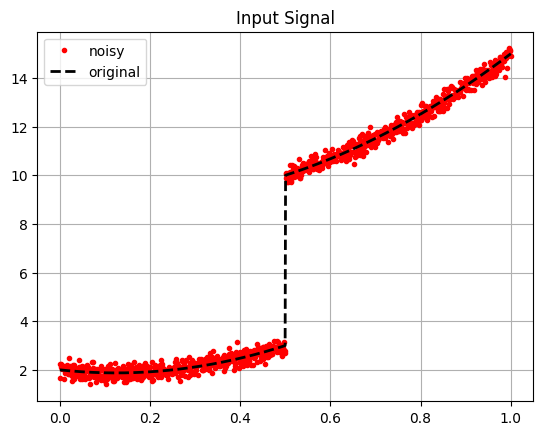

In [60]:
plt.figure()
plt.plot(ty, s, 'r.')
plt.plot(ty, y, 'k--', linewidth=2)
plt.grid()
plt.legend(['noisy', 'original'])
plt.title('Input Signal')

Define the matrix T containing the polynomials sampled over the window

In [61]:
t = np.arange(1,M+1)
T = np.ones((M,N+1))
T[:,1] = t
for i in range(2,N+1):
  T[:,i] = T[:,i-1] * t

Construct the LPA kernel

In [62]:
# comput the qr decomposition of WT
# since T has more rows than columns, then qr computes only the first N + 1 columns of Q and the first N + 1 rows of R.
Q, R = np.linalg.qr(W @ T, mode="reduced")

#  define Qtilde
Qtilde =  Winv @ Q

# adjust Qtilde with the  weights matrix squared.
W2Qtilde = Qtilde.T @ W**2

# select the central row of W2Qtilde
row = Qtilde[Qtilde.shape[0]//2]

# compute the kernel
g = row @ W2Qtilde

# flipping, since it is used in convolution
g = np.flip(g)

Text(0.5, 1.0, 'filter M = 53, N = 2')

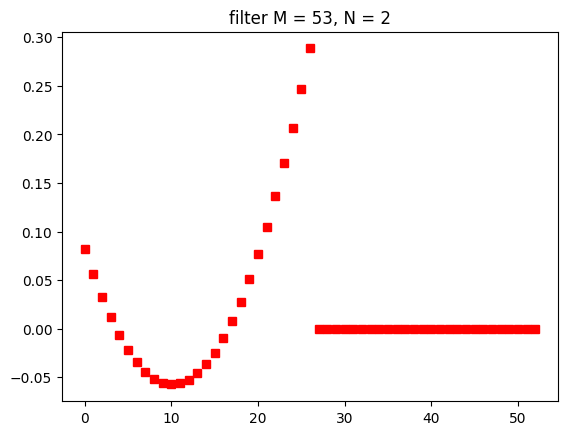

In [63]:
plt.figure()
plt.plot(g, 'rs', linewidth=3)
plt.title(f'filter M = {M:d}, N = {N:d}')

Filtering


In [64]:
s_pad = np.pad(s, (M//2, M//2), mode='constant')
shat = np.zeros(LENGHT)
for i in range(0,LENGHT):
  shat[i] = np.convolve(g,s_pad[i:i+M], 'valid')[0]

In [65]:
shat = np.convolve(s,g, mode='same')

Text(0.5, 1.0, 'M = 53, N = 2')

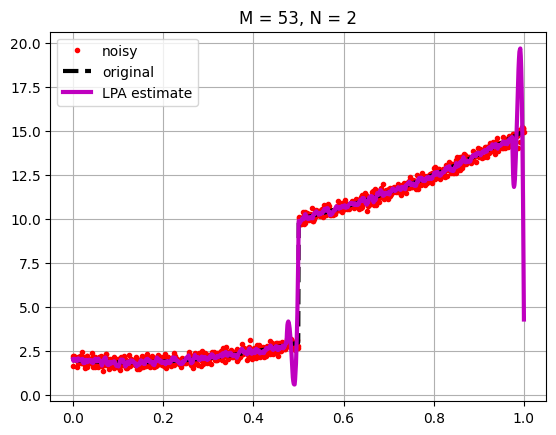

In [66]:
plt.figure()
plt.plot(ty, s, 'r.')
plt.plot(ty, y, 'k--', linewidth=3)
plt.plot(ty, shat, 'm-', linewidth=3)
plt.grid()
plt.legend(['noisy', 'original', 'LPA estimate'])
plt.title(f'M = {M:d}, N = {N:d}')